In [2]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
desired_res = (24, 24, 24)
# Desired resolution (modify as needed)
desired_res = (32, 32, 32)
hyperparams = {
    'learning_rate': 5e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'decay_epoch': 25,
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
num_epochs = 50
print_every = 1
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    (2, 2, 1)      # No pooling after the third stage
]

In [4]:
import os
print(os.listdir('../'))

['best_models', 'classification_knots_3d_arrays_weak_tunning', 'classification_knots_spectrum_strong_tunning', 'data_generation', 'HOPFS_L270_0.05_1_64x64x64_v1', 'HOPFS_L270_5e-07_test_1s']


In [6]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}
# knot_types = {
#
#     'optimized': 0,  # 6
#
#     'dennis': 1,
#
#     'trefoil_optimized': 2,
#
#
# }

knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]
knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]
# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
folders = [
    '../HOPFS_L270_0.05_1000_64x64x64_v1',
    '../HOPFS_L270_0.15_1000_64x64x64_v1',
    '../HOPFS_L270_0.25_1000_64x64x64_v1',
]
# folders = [
#     '../HOPFS_L270_0.05_1_64x64x64_v1',
#     '../HOPFS_L270_5e-07_test_1s',
# ]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True



# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Deserialize the JSON string back to a list
                    data_list = json.loads(row[0])
                    data_array = np.array(data_list)

                    # Extract points and dimensions
                    points_list = data_array[2:]
                    Nx, Ny, Nz = data_array[1]

                    if flag_print_shape:
                        print(f'Shape: {Nx}, {Ny}, {Nz}')
                        flag_print_shape = False

                    # Rescale if necessary
                    if desired_res != (Nx, Ny, Nz):
                        scale_x = desired_res[0] / Nx
                        scale_y = desired_res[1] / Ny
                        scale_z = desired_res[2] / Nz
                        points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

                    # Initialize a 3D array and set points to 1
                    dots_3d = np.zeros(desired_res, dtype=int)
                    for x, y, z in points_list:
                        try:
                            dots_3d[x, y, z] = 1
                        except IndexError:
                            continue

                    # Append to lists
                    X_list.append(dots_3d)
                    Y_list.append(knot_types[knot])

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 100
Loaded 132 samples.  11.0 per class


In [44]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([240, 1, 24, 24, 24]) torch.Size([240, 12])


In [45]:

train_dataset = TensorDataset(X_torch, y_torch)


In [46]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x


In [47]:


model = Classifier3D(stages, pooling_configs, num_classes=len(knots)).to(device)
model.initialize_weights()

In [48]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch))
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([1, 1, 24, 24, 24])
tensor([[ 0.2085, -0.0280, -0.0681, -0.0926,  0.0725,  0.0316, -0.0024,  0.0902,
         -0.0154, -0.0282,  0.0617,  0.1125]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 24, 24, 24]             896
       BatchNorm3d-2       [-1, 32, 24, 24, 24]              64
              ReLU-3       [-1, 32, 24, 24, 24]               0
            Conv3d-4       [-1, 32, 24, 24, 24]          27,680
       BatchNorm3d-5       [-1, 32, 24, 24, 24]              64
              ReLU-6       [-1, 32, 24, 24, 24]               0
            Conv3d-7       [-1, 32, 24, 24, 24]          27,680
       BatchNorm3d-8       [-1, 32, 24, 24, 24]              64
              ReLU-9       [-1, 32, 24, 24, 24]               0
        MaxPool3d-10       [-1, 32, 13, 13, 13]               0
           Conv3d-11       [-1, 64, 11, 11, 11

In [49]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [50]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)


train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
# test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
scheduler.step(-1)
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(0)

    if epoch == hyperparams['decay_epoch'] -1:
        scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')


Progress:  10%|█         | 1/10 [00:07<01:10,  7.87s/it]

Epoch 0 completed in 7.87 seconds
Epoch 0: Train Loss: 2.4893, Val Loss: 2.4838


Progress:  20%|██        | 2/10 [00:16<01:06,  8.31s/it]

Epoch 1 completed in 8.63 seconds
Epoch 1: Train Loss: 2.4650, Val Loss: 2.4837


Progress:  30%|███       | 3/10 [00:23<00:55,  7.87s/it]

Epoch 2 completed in 7.34 seconds
Epoch 2: Train Loss: 2.4472, Val Loss: 2.4837


Progress:  40%|████      | 4/10 [00:29<00:43,  7.20s/it]

Epoch 3 completed in 6.16 seconds
Epoch 3: Train Loss: 2.4285, Val Loss: 2.4840


Progress:  50%|█████     | 5/10 [00:36<00:34,  6.81s/it]

Epoch 4 completed in 6.12 seconds
Epoch 4: Train Loss: 2.4122, Val Loss: 2.4844


Progress:  60%|██████    | 6/10 [00:42<00:26,  6.59s/it]

Epoch 5 completed in 6.18 seconds
Epoch 5: Train Loss: 2.3939, Val Loss: 2.4849


Progress:  70%|███████   | 7/10 [00:48<00:19,  6.45s/it]

Epoch 00007: reducing learning rate of group 0 to 2.0000e-06.
Epoch 6 completed in 6.16 seconds
Epoch 6: Train Loss: 2.3799, Val Loss: 2.4851


Progress:  80%|████████  | 8/10 [00:54<00:12,  6.37s/it]

Epoch 7 completed in 6.19 seconds
Epoch 7: Train Loss: 2.3639, Val Loss: 2.4851


Progress:  90%|█████████ | 9/10 [01:00<00:06,  6.32s/it]

Epoch 8 completed in 6.21 seconds
Epoch 8: Train Loss: 2.3594, Val Loss: 2.4848


Progress: 100%|██████████| 10/10 [01:07<00:00,  6.71s/it]

Epoch 9 completed in 6.19 seconds
Epoch 9: Train Loss: 2.3563, Val Loss: 2.4842
Total training time: 67.06 seconds


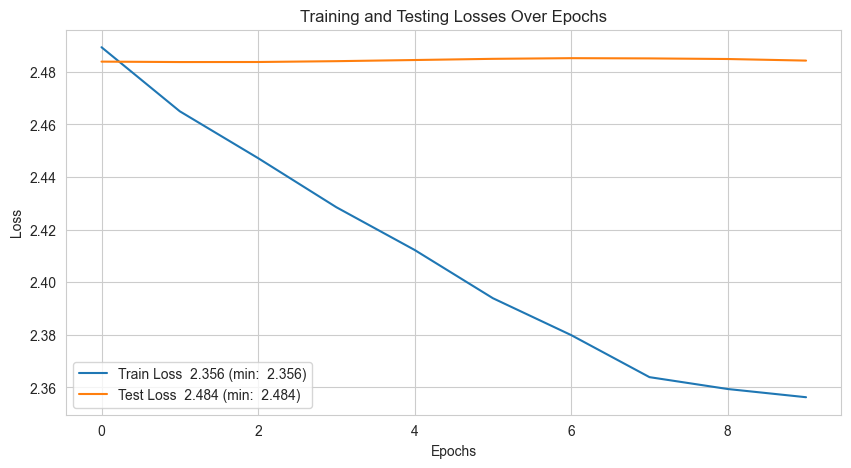

In [51]:
plot_losses(train_losses, val_losses, decimals=3)

In [ ]:
# Save the model state (weights) and structure
model_save_path = "classifier_knots_3d_32_full.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': hyperparams,
    'num_classes': num_classes,
    'stages': stages,
    'pooling_configs': pooling_configs,
    'desired_res': desired_res,
}, model_save_path)

print(f"Model saved to {model_save_path}")